In [3]:
import numpy as np
print("Bayesian Hierarchical Sampler Notebook Initialized ✅")

Bayesian Hierarchical Sampler Notebook Initialized ✅


# Bayesian Hierarchical Linear Regression

This notebook demonstrates a full Bayesian treatment of linear regression with a hierarchical prior structure. The model accounts for group-level variation using random intercepts, and uses Gibbs sampling for posterior inference.

All inference is built from scratch using NumPy and standard Python libraries — no high-level probabilistic libraries (e.g. PyMC3 or Stan) are used. This serves both as a learning exercise and a practical template for custom Bayesian workflows.


## Model Structure

We model the outcome \( y_i \) as:

\[
y_i = \mathbf{x}_i^\top \boldsymbol{\beta} + \gamma_{g(i)} + \epsilon_i, \quad \epsilon_i \sim \mathcal{N}(0, \sigma^2)
\]

Where:

- \( \boldsymbol{\beta} \) are global regression coefficients
- \( \gamma_{g(i)} \) is a group-specific intercept for the group \( g(i) \) of observation \( i \)
- \( \sigma^2 \) is the global noise variance

The priors are:

\[
\boldsymbol{\beta} \mid \sigma^2 \sim \mathcal{N}(\boldsymbol{\mu}_0, \sigma^2 \Lambda_0^{-1}), \quad \sigma^2 \sim \text{Inv-Gamma}(\alpha_0, \beta_0)
\]
\[
\gamma_j \mid \tau^2 \sim \mathcal{N}(0, \tau^2), \quad \tau^2 \sim \text{Inv-Gamma}(\alpha_\tau, \beta_\tau)
\]

This hierarchical structure allows partial pooling across groups and reflects our uncertainty at multiple levels.


In [29]:
# 1. Simulate synthetic dataset
import numpy as np

rng = np.random.default_rng(seed=42)
n, p, J = 100, 2, 5

X = rng.normal(size=(n, p))
true_beta = np.array([1.0, -2.0])
groups = rng.integers(low=0, high=J, size=n)
true_gamma = rng.normal(0, 1, size=J)
y = X @ true_beta + true_gamma[groups] + rng.normal(0, 1, size=n)


In [30]:
# 2. Fix path so Python can find the module in `inference/`
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)


In [31]:
# 3. Import the class
from inference.gibbs_sampler import BayesianHierarchicalLinearRegression

In [32]:
# 4. Set priors and initialize sampler
mu0 = np.zeros(p)
Lambda0 = np.eye(p) * 0.01
alpha0, beta0 = 2.0, 2.0
alpha_tau, beta_tau = 2.0, 2.0

sampler = BayesianHierarchicalLinearRegression(
    X=X,
    y=y,
    groups=groups,
    mu0=mu0,
    Lambda0=Lambda0,
    alpha0=alpha0,
    beta0=beta0,
    alpha_tau=alpha_tau,
    beta_tau=beta_tau,
    random_state=42
)

In [33]:
# 5. Run Gibbs sampler
sampler.run_gibbs(n_iter=2000, burn_in=1000)


In [34]:
# 6. Print posterior mean of beta
print("Posterior mean of beta:", sampler.samples_["beta"].mean(axis=0))


Posterior mean of beta: [ 0.93588884 -1.88278476]


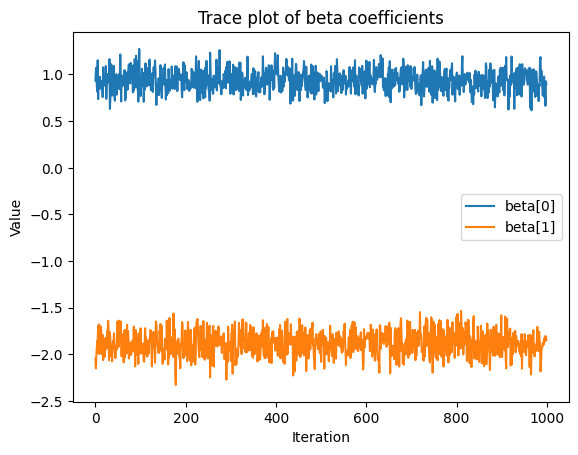

In [35]:
# Trace plots (check convergence visually):

import matplotlib.pyplot as plt

for i in range(p):
    plt.plot(sampler.samples_["beta"][:, i], label=f"beta[{i}]")
plt.title("Trace plot of beta coefficients")
plt.xlabel("Iteration")
plt.ylabel("Value")
plt.legend()
plt.show()


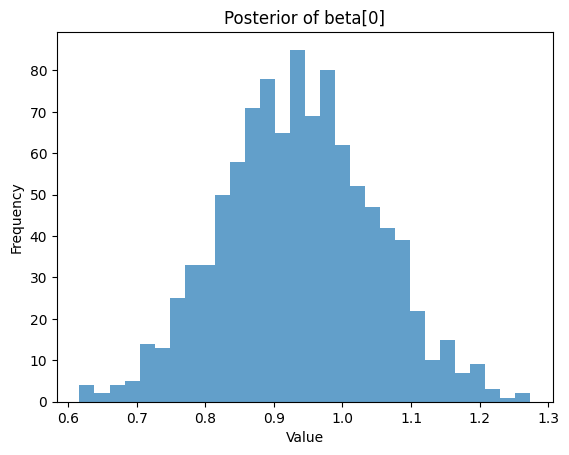

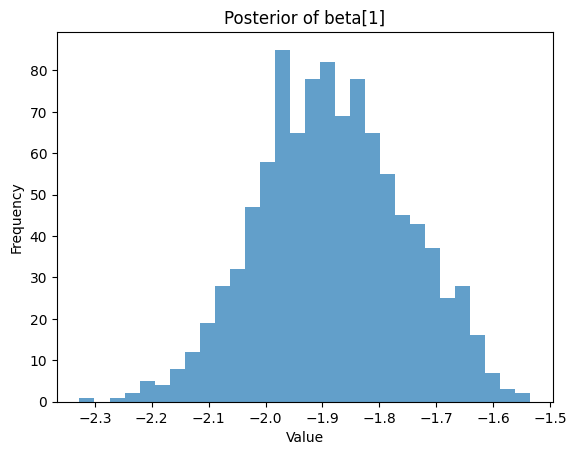

In [36]:
# Posterior distribution (histograms):

for i in range(p):
    plt.hist(sampler.samples_["beta"][:, i], bins=30, alpha=0.7)
    plt.title(f"Posterior of beta[{i}]")
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.show()


In [37]:
# Shrinkage effect (compare to OLS):

from sklearn.linear_model import LinearRegression

ols = LinearRegression().fit(X, y)
print("OLS coefficients:", ols.coef_)


OLS coefficients: [ 1.02011871 -2.52152807]


In [38]:
# Posterior Summary for beta

import numpy as np

beta_samples = sampler.samples_["beta"]
beta_mean = beta_samples.mean(axis=0)
beta_std = beta_samples.std(axis=0)
beta_ci = np.percentile(beta_samples, [2.5, 97.5], axis=0)

print("Posterior Summary for β (regression coefficients):")
for i in range(beta_samples.shape[1]):
    print(f"  beta[{i}] -> mean: {beta_mean[i]:.3f}, std: {beta_std[i]:.3f}, 95% CI: [{beta_ci[0, i]:.3f}, {beta_ci[1, i]:.3f}]")


Posterior Summary for β (regression coefficients):
  beta[0] -> mean: 0.936, std: 0.111, 95% CI: [0.720, 1.156]
  beta[1] -> mean: -1.883, std: 0.130, 95% CI: [-2.129, -1.639]


In [39]:
# Posterior Summary for sigma²

sigma2_samples = sampler.samples_["sigma2"]
sigma2_mean = np.mean(sigma2_samples)
sigma2_std = np.std(sigma2_samples)
sigma2_ci = np.percentile(sigma2_samples, [2.5, 97.5])

print(f"Posterior Summary for σ² (noise variance):")
print(f"  mean: {sigma2_mean:.3f}, std: {sigma2_std:.3f}, 95% CI: [{sigma2_ci[0]:.3f}, {sigma2_ci[1]:.3f}]")


Posterior Summary for σ² (noise variance):
  mean: 0.998, std: 0.145, 95% CI: [0.752, 1.313]


In [40]:
# Posterior Summary for tau²

tau2_samples = sampler.samples_["tau2"]
tau2_mean = np.mean(tau2_samples)
tau2_std = np.std(tau2_samples)
tau2_ci = np.percentile(tau2_samples, [2.5, 97.5])

print(f"Posterior Summary for τ² (group variance):")
print(f"  mean: {tau2_mean:.3f}, std: {tau2_std:.3f}, 95% CI: [{tau2_ci[0]:.3f}, {tau2_ci[1]:.3f}]")


Posterior Summary for τ² (group variance):
  mean: 3.204, std: 1.929, 95% CI: [1.140, 8.630]


In [41]:
# Posterior Summary for a few gamma[j]

gamma_samples = sampler.samples_["gamma"]
J = gamma_samples.shape[1]

print("Posterior Summary for a few γ[j] (group intercepts):")
for j in range(min(J, 5)):  # adjust range if you want more
    mean_j = gamma_samples[:, j].mean()
    std_j = gamma_samples[:, j].std()
    ci_j = np.percentile(gamma_samples[:, j], [2.5, 97.5])
    print(f"  gamma[{j}] -> mean: {mean_j:.3f}, std: {std_j:.3f}, 95% CI: [{ci_j[0]:.3f}, {ci_j[1]:.3f}]")


Posterior Summary for a few γ[j] (group intercepts):
  gamma[0] -> mean: -1.380, std: 0.208, 95% CI: [-1.778, -0.981]
  gamma[1] -> mean: -1.106, std: 0.260, 95% CI: [-1.587, -0.572]
  gamma[2] -> mean: 1.794, std: 0.221, 95% CI: [1.379, 2.242]
  gamma[3] -> mean: 3.269, std: 0.230, 95% CI: [2.817, 3.727]
  gamma[4] -> mean: -1.035, std: 0.212, 95% CI: [-1.456, -0.614]


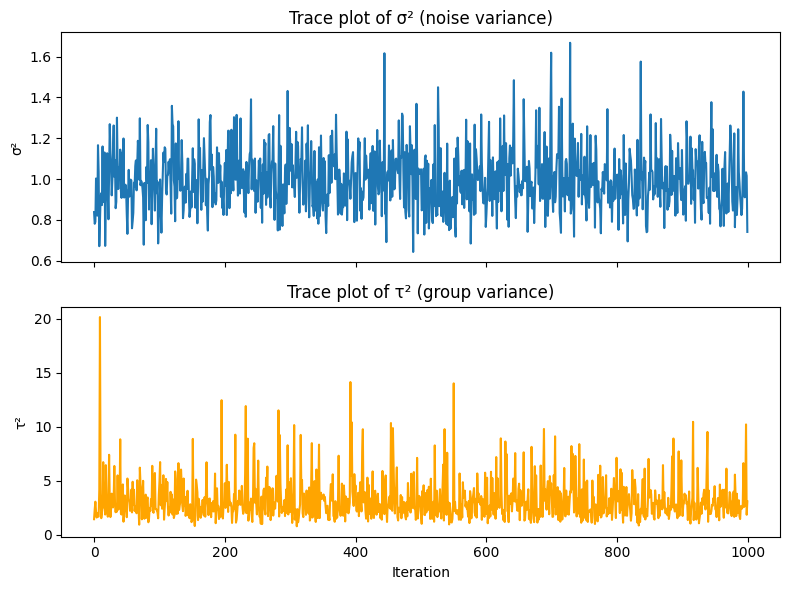

In [42]:
# Trace Plot for σ² and τ²

import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

ax[0].plot(sigma2_samples)
ax[0].set_title("Trace plot of σ² (noise variance)")
ax[0].set_ylabel("σ²")

ax[1].plot(tau2_samples, color='orange')
ax[1].set_title("Trace plot of τ² (group variance)")
ax[1].set_ylabel("τ²")
ax[1].set_xlabel("Iteration")

plt.tight_layout()
plt.show()


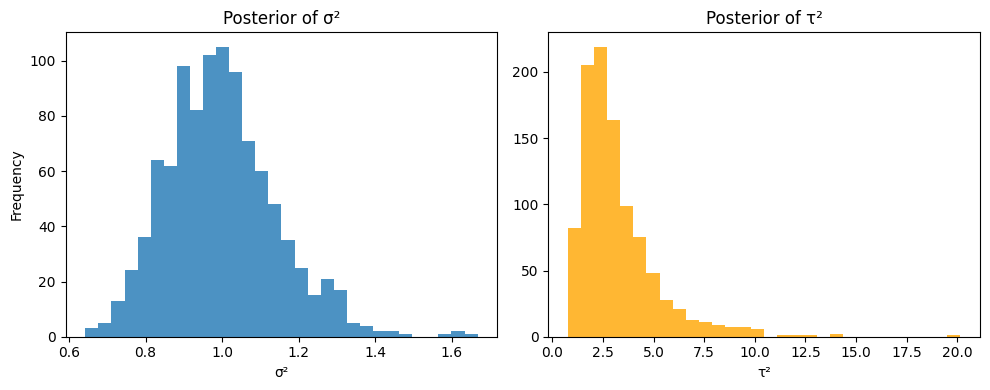

In [43]:
# Histogram for σ² and τ²

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].hist(sigma2_samples, bins=30, alpha=0.8)
ax[0].set_title("Posterior of σ²")
ax[0].set_xlabel("σ²")
ax[0].set_ylabel("Frequency")

ax[1].hist(tau2_samples, bins=30, alpha=0.8, color='orange')
ax[1].set_title("Posterior of τ²")
ax[1].set_xlabel("τ²")

plt.tight_layout()
plt.show()


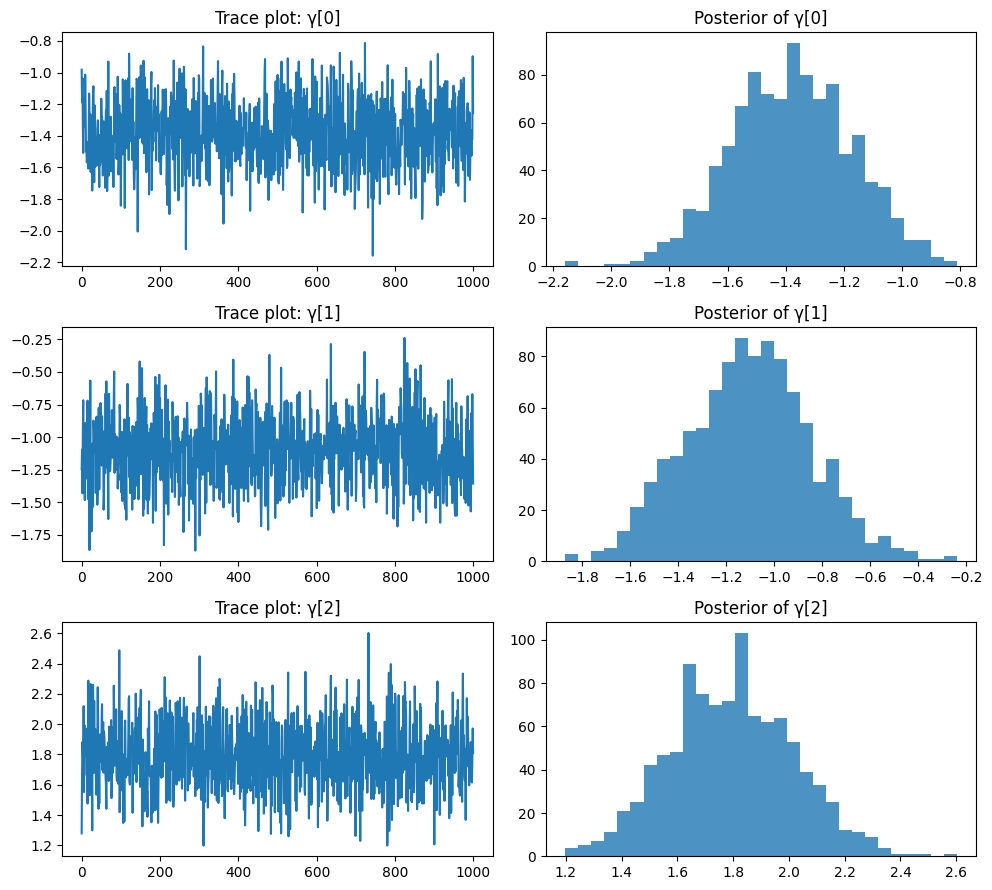

In [44]:
# Trace + Histogram for a few γ_j

J = gamma_samples.shape[1]
n_plot = min(3, J)  # number of groups to show

fig, axes = plt.subplots(n_plot, 2, figsize=(10, 3 * n_plot))

for i in range(n_plot):
    axes[i, 0].plot(gamma_samples[:, i])
    axes[i, 0].set_title(f"Trace plot: γ[{i}]")

    axes[i, 1].hist(gamma_samples[:, i], bins=30, alpha=0.8)
    axes[i, 1].set_title(f"Posterior of γ[{i}]")

plt.tight_layout()
plt.show()


In [45]:
# Posterior Summaries

import pandas as pd

# Summarize posterior distributions (means and 95% credible intervals)
summary = {
    'Mean': sampler.samples_['beta'].mean(axis=0),
    '2.5%': np.percentile(sampler.samples_['beta'], 2.5, axis=0),
    '97.5%': np.percentile(sampler.samples_['beta'], 97.5, axis=0)
}
df_beta_summary = pd.DataFrame(summary, index=[f'beta[{i}]' for i in range(p)])
df_beta_summary


,Mean,2.5%,97.5%
beta[0],0.935889,0.719776,1.156471
beta[1],-1.882785,-2.129132,-1.638629


In [46]:
# Comparing Bayesian vs OLS

from sklearn.linear_model import LinearRegression

ols = LinearRegression().fit(X, y)
print("OLS coefficients:", ols.coef_)




OLS coefficients: [ 1.02011871 -2.52152807]


### Posterior vs OLS

The Bayesian posterior mean estimates for the beta coefficients are compared to the frequentist OLS estimates.

- OLS provides point estimates without uncertainty.
- Bayesian inference gives full posterior distributions, capturing uncertainty and prior influence.


In [47]:
# Save beta posterior summary to CSV
df_beta_summary.to_csv("../results/beta_posterior_summary.csv", index=True)
